People want to correct for gene expression. They can do it better by using Harmony soft clusters. 

In [2]:
library(tidyverse)
library(data.table)
library(magrittr)
library(ggthemes)
library(harmony)
library(singlecellmethods)
library(ggrepel)
library(Matrix)
library(patchwork)
library(sctransform)
library(ggrastr)
library(scales)
library(uwot)
library(pheatmap)


In [3]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}


In [4]:
do_scatter <- function(umap_use, meta_data, label_name, no_guides = TRUE, do_labels = TRUE, nice_names, palette_use,
                       pt_size = 4, point_size = .5, base_size = 12, do_points = TRUE, do_density = FALSE, h = 6, w = 8) {
    plt_df <- umap_use %>% data.frame() %>% 
        cbind(meta_data) %>% 
        dplyr::sample_frac(1L) 
    plt_df$given_name <- plt_df[[label_name]]
    
    if (!missing(nice_names)) {
        plt_df %<>%
            dplyr::inner_join(nice_names, by = "given_name") %>% 
            subset(nice_name != "" & !is.na(nice_name))

        plt_df[[label_name]] <- plt_df$nice_name        
    }
        
    plt <- plt_df %>% 
        ggplot(aes_string("X1", "X2", col = label_name, fill = label_name)) + 
#         theme_tufte(base_size = base_size) + 
        theme_test(base_size = base_size) + 
        theme(panel.background = element_rect(fill = NA, color = "black")) + 
        guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 4)), alpha = FALSE) +
        scale_color_manual(values = palette_use) + 
        scale_fill_manual(values = palette_use) +    
        theme(plot.title = element_text(hjust = .5)) + 
        labs(x = "UMAP 1", y = "UMAP 2") 
    
    if (do_points) 
#         plt <- plt + geom_point_rast(dpi = 300, width = w, height = h, size = point_size) 
        plt <- plt + geom_point(shape = '.')
    if (do_density) 
        plt <- plt + geom_density_2d()    
        

    if (no_guides)
        plt <- plt + guides(col = FALSE, fill = FALSE, alpha = FALSE)
    
    if (do_labels) 
        plt <- plt + geom_label_repel(data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = label_name], label.size = NA,
                                      aes_string(label = label_name), color = "white", size = pt_size, alpha = 1, segment.size = 0) + 
        guides(col = FALSE, fill = FALSE)
    return(plt)
}


# Motivation

Library complexity and batch effects are not orthogonal to Biology!!!!



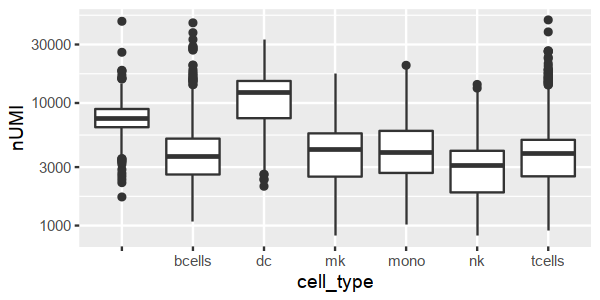

In [122]:
fig.size(2.5, 5)
meta_data %>% 
    ggplot(aes(cell_type, nUMI)) + 
        geom_boxplot() + 
        scale_y_log10() + 
        NULL

# Linear correction of logCPM

    - do Harmony, keep soft clusters
    - do MoE for genes
    - redo PCA and UMAP and see if batch effect is gone
    - compare to global linear regression (i.e. with Seurat scaling)

## Harmony

In [7]:
V <- fread('/data/srlab/ik936/harmony_paper/PBMC_full/data/scaled_pcs.csv')
meta_data <- fread('/data/srlab/ik936/harmony_paper/PBMC_full/data/meta_data_subtypes.csv')
exprs_norm <- readRDS('/data/srlab/ik936/harmony_paper/PBMC_full/data/exprs_norm.rds')


In [8]:
harmonyObj <- HarmonyMatrix(V, meta_data, 'donor', theta = 2, lambda = .1, nclust = 50,
                    max.iter.cluster = 10, max.iter.harmony = 5, return_object = TRUE)

Harmony 1/5
Harmony 2/5
Harmony 3/5
Harmony 4/5
Harmony 5/5


In [9]:
umap_res <- umap(t(harmonyObj$Z_corr), n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
                 min_dist = .1, n_threads = 4, approx_pow = TRUE)


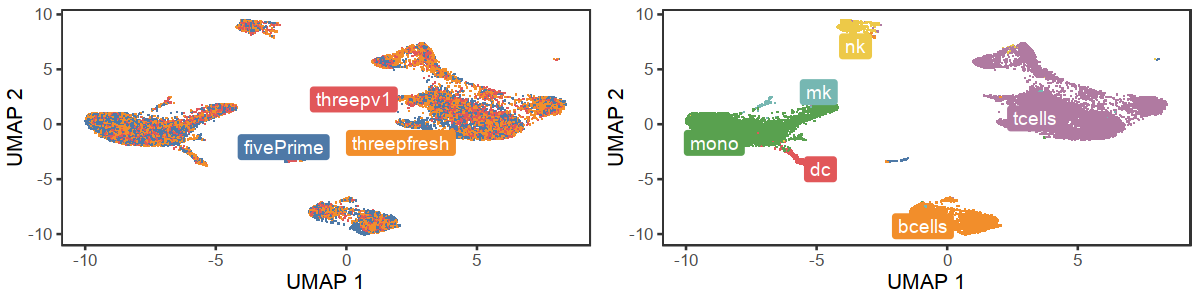

In [10]:
fig.size(2.5, 10)
do_scatter(umap_res, meta_data, 'donor', palette_use = tableau_color_pal()(10)) + 
do_scatter(umap_res, meta_data, 'cell_type', palette_use = tableau_color_pal()(10))

## Gene correction

In [33]:
sourceCpp('utils.cpp')

In [34]:
exprs_dense <- as.matrix(exprs_norm)

In [35]:
system.time({
    with(harmonyObj, {
        X_corr <<- moe_gene(as.matrix(exprs_dense), Phi_moe, R, lambda)
    })
})


   user  system elapsed 
 78.511   1.378   5.335 

In [690]:
row.names(X_corr) <- row.names(exprs_dense)
colnames(X_corr) <- colnames(exprs_dense)

### redo PCA + UMAP

In [36]:
pca_res <- X_corr %>% t %>% scale(T, T) %>% t %>% rARPACK::svds(20, 0, 20)
V2 <- pca_res$v %*% diag(pca_res$d)


In [37]:
umap2 <- umap(V2, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)


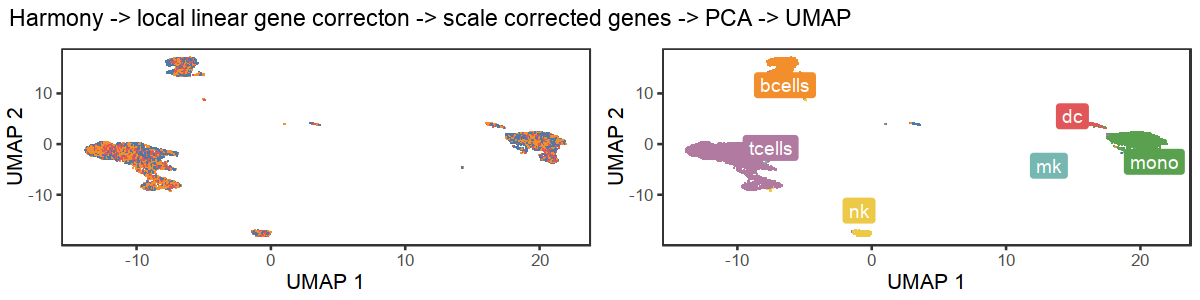

In [38]:
fig.size(2.5, 10)
idx <- which(!is.na(meta_data$cell_type))
do_scatter(umap2[idx, ], meta_data[idx, ], 'donor', palette_use = tableau_color_pal()(10), do_labels = FALSE) + 
do_scatter(umap2[idx, ], meta_data[idx, ], 'cell_type', palette_use = tableau_color_pal()(10)) + 
plot_annotation('Harmony -> local linear gene correcton -> scale corrected genes -> PCA -> UMAP')

## Compare to global ridge linear regression

In [39]:
harmonyObj$R %>% dim

[1]    50 20886

In [696]:
system.time({
    with(harmonyObj, {
        X_lin <<- moe_gene(as.matrix(exprs_dense), Phi_moe, matrix(1, nrow = 1, ncol = ncol(harmonyObj$R)), lambda)
    })
})


row.names(X_lin) <- row.names(exprs_dense)
colnames(X_lin) <- colnames(exprs_dense)

   user  system elapsed 
  1.748   1.058   1.322 

In [41]:
pca_res <- X_lin %>% t %>% scale(T, T) %>% t %>% rARPACK::svds(20, 0, 20)
V3 <- pca_res$v %*% diag(pca_res$d)


In [42]:
umap3 <- umap(V3, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
              min_dist = .1, n_threads = 4, approx_pow = TRUE)


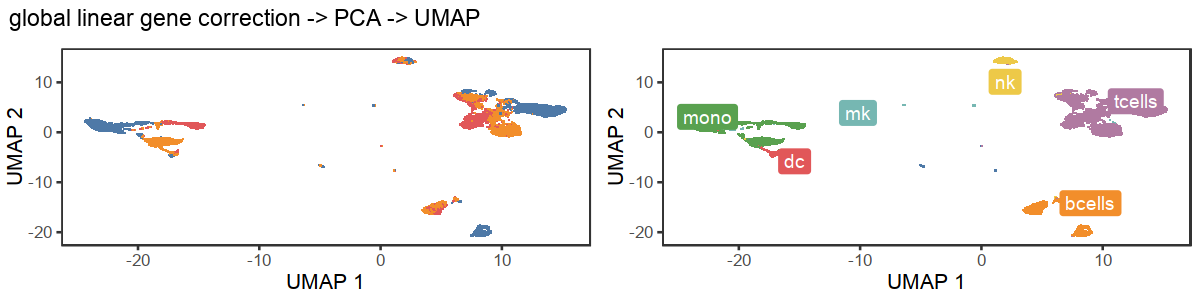

In [43]:
fig.size(2.5, 10)
idx <- which(!is.na(meta_data$cell_type))
do_scatter(umap3[idx, ], meta_data[idx, ], 'donor', palette_use = tableau_color_pal()(10), do_labels = FALSE) + 
do_scatter(umap3[idx, ], meta_data[idx, ], 'cell_type', palette_use = tableau_color_pal()(10)) + 
plot_annotation(title = 'global linear gene correction -> PCA -> UMAP')

# Poisson

    weighted Poisson regression 
    
    
    GOAL: 
        do Poisson regression of main markers
        compare to linear regression of same markers
        

## Get raw data 

In [5]:
x1 <- readRDS("/data/srlab/ik936/Foxxy/data/cache_pbmc_3pv1.rds")$exprs_raw
x2 <- readRDS("/data/srlab/ik936/Foxxy/data/cache_pbmc_3pv2.rds")$exprs_raw
x3 <- readRDS("/data/srlab/ik936/Foxxy/data/cache_pbmc_5p.rds")$exprs_raw

In [11]:
exprs_raw <- Reduce(cbind, list(x1, x2, x3))[row.names(exprs_norm), colnames(exprs_norm)]

## Estimate expert parameters

For each cluster, learn a ridge-penalized weighted Poisson model: 

    exprs_raw ~ log(nUMI) + batch


In [12]:
library(glmnet)

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16



In [13]:
# meta_use <- meta_data[, c('nUMI', 'donor')]
# meta_use$nUMI <- log(meta_use$nUMI)
meta_use <- data.frame(t(harmonyObj$Phi_moe[2:4, ]))
meta_use$nUMI <- log(meta_data$nUMI)
meta_use <- as.matrix(meta_use)

In [14]:
mean(exprs_raw['MS4A1', ])
mean(exprs_raw['CD14', ])

[1] 0.712008

[1] 0.7181844

In [101]:
pres <- Reduce(cbind, lapply(1:harmonyObj$K, function (k) {
#     x <- glmnet::glmnet(meta_use, exprs_raw['MS4A1', ], family = 'poisson', intercept = TRUE, weights = harmonyObj$R[k, ], alpha = 0)
    x <- glmnet::glmnet(meta_use, log1p(exprs_raw['CD3E', ]), family = 'gaussian', intercept = TRUE, weights = harmonyObj$R[k, ], alpha = 0, lambda = 1)
#     x <- glmnet::glmnet(meta_use, log(1 + exprs_raw['CD3E', ]), family = 'gaussian', intercept = TRUE, weights = harmonyObj$R[k, ], alpha = 0, lambda = 1)
#     lambda_idx <- min(which((diff(x$dev.ratio) / tail(x$dev.ratio, -1)) < .01))
#     lambda_idx <- 50
#     data.frame(c(x$a0[lambda_idx], x$beta[, lambda_idx]))    
    data.frame(c(x$a0[1], x$beta[, 1]))    
}))

pres <- data.table(t(pres))

In [102]:
fig.size(2.5, 5)
tcrossprod(harmonyObj$R, t(harmony:::onehot(meta_data$cell_type))) %>% round %>%
    cbind(
        pres
    ) %>% 
    tibble::rowid_to_column('cluster') 

cluster,V1,bcells,dc,mk,mono,nk,tcells,s0,X1,X2,X3,nUMI
1,0,1,0,0,0,8,364,-0.85182196,0.229491426,-0.037482856,-0.170800623,0.26143942
2,0,0,0,0,0,0,450,-0.82508769,0.186204721,-0.055333431,-0.142251014,0.25034563
3,0,0,0,1,401,0,0,-0.26037555,-0.006188375,0.020905460,-0.013002439,0.04412113
4,0,1,0,0,2,434,34,-0.89634126,0.095488858,0.002262912,-0.098909823,0.18121190
5,0,1,0,0,0,0,449,-0.79958892,0.200096462,-0.059867183,-0.153265660,0.25142348
6,0,0,2,2,458,0,0,-0.10843841,-0.006229278,0.009520894,-0.004404784,0.02082503
7,1,396,0,0,1,0,0,-0.39669013,-0.020856503,0.024085536,-0.004895008,0.06110343
8,0,0,0,0,1,0,465,-0.79661423,0.197460966,-0.062037249,-0.159979133,0.25165223
9,0,435,0,0,1,0,0,-0.31708385,-0.011402677,0.012955182,-0.002641205,0.04918546
10,0,0,0,0,0,0,450,-0.83127338,0.183522514,-0.054400020,-0.140423886,0.25047072


## Estimate cell distribution

Model each cell as a mixture of Poissons, based on Harmony soft clusters


Then compute Pearson residuals of genes inside each cell 


M-step of Poisson mixture EM algorithm

https://www.cs.helsinki.fi/u/bmmalone/probabilistic-models-spring-2014/mixture-of-poissons.pdf

https://www.cs.helsinki.fi/u/bmmalone/probabilistic-models-spring-2014/PoissonMixtureModels.pdf




In [103]:
expected_logUMI <- tcrossprod(harmonyObj$R, matrix(log(meta_data$nUMI), nrow = 1)) / rowSums(harmonyObj$R)
head(expected_logUMI)

8.009762
8.174762
8.670552
7.994048
8.232074
8.110818


In [107]:
## find residuals for each cluster
mu <- exp(tcrossprod(cbind(1, meta_use), as.matrix(pres)))
# resid <- sweep(-mu, 1, exprs_raw['CD3E', , drop = FALSE], '+')
resid <- sweep(-mu, 1, log1p(exprs_raw['CD3E', , drop = FALSE]), '+')

## compute mean expression of 1 cell within each cluster
## each cluster can have different depth 
expert_means <- exp(pres[, 1] + pres[, 'nUMI'] * expected_logUMI) %>% unlist %>% as.numeric
# expert_means <- exp(pres[, 1] + pres[, 'nUMI'] * log(1e4)) %>% unlist %>% as.numeric

## add residual counts to batch free counts
counts <- sweep(resid, 2, expert_means, '+')
counts <- rowSums(counts * t(harmonyObj$R))

In [108]:
split(counts, meta_data$cell_type) %>% lapply(mean)
split(exprs_raw['CD3E', ], meta_data$cell_type) %>% lapply(mean)

[[1]]
[1] 0.1276824

$bcells
[1] 0.0893277

$dc
[1] 0.1603252

$mk
[1] 0.2676139

$mono
[1] 0.09729368

$nk
[1] 0.4914245

$tcells
[1] 1.158907

[[1]]
[1] 0.2512821

$bcells
[1] 0.2124041

$dc
[1] 0.3366834

$mk
[1] 0.5959596

$mono
[1] 0.2052379

$nk
[1] 1.150759

$tcells
[1] 3.292206

In [71]:
data.table(meta_data)[, median(nUMI), by = cell_type]

cell_type,V1
bcells,3672.0
mono,3970.5
tcells,3877.0
dc,12228.0
nk,3105.0
mk,4162.0
,7416.0


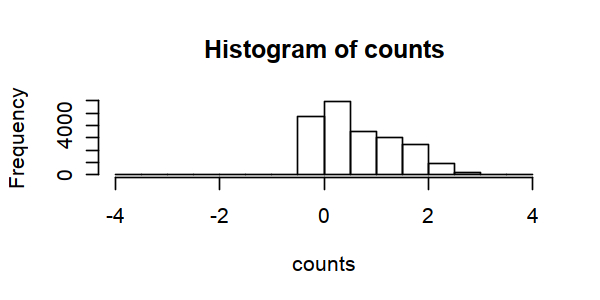

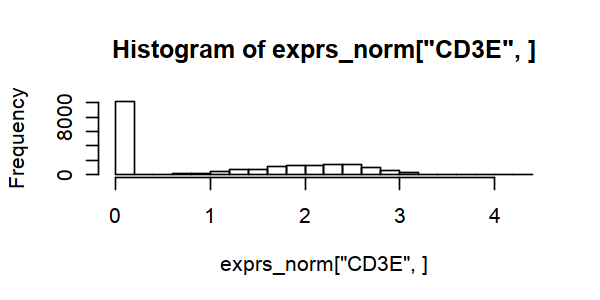

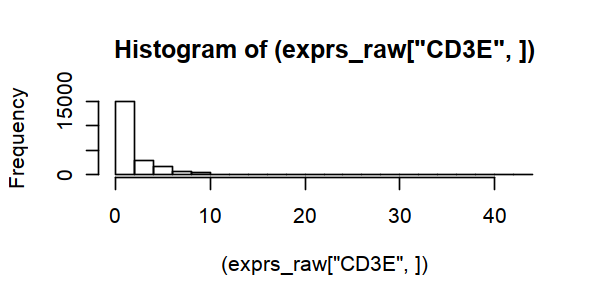

In [109]:
hist(counts)
# hist(X_lin['CD3E', ])
# hist(log1p(counts))
hist(exprs_norm['CD3E', ])
hist((exprs_raw['CD3E', ]))
# hist(log1p(exprs_raw['CD3E', ]))


In [32]:
mean(log1p(counts))
var(log1p(counts))

[1] 0.7128315

[1] 0.5784796

# Speed issues

It is super super slow to do the Poisson model for every single fucking gene

What are the alternatives? 

    - Linear regression? It gives a pretty good PCA result. We can also correct for nUMI to account for depth. 
    - Christoph uses only 2000 genes and estimates mu and theta with smoothing for the rest
    - Some kind of approximation? 

## Linear approximations

    1) account for nUMI confounded with 
    2) 
    3) compare how Gaussian the result is compare to Poisson

# Better linear model

## GOAL1: model log(nUMI)

    - Let's model the raw counts directly, not the CPM. 
    - Will I get the same results as in glmnet? 


In [33]:
sourceCpp('utils.cpp')

In [94]:
# exprs_dense <- log1p(as.matrix(exprs_norm))
exprs_dense <- log1p(as.matrix(exprs_raw))
X <- as.matrix(exprs_dense[c('CD3E', 'CD14'), , drop = FALSE])
R <- harmonyObj$R

design <- harmonyObj$Phi_moe
design <- rbind(design, log(meta_data$nUMI))
lambda <- diag(c(0, rep(1, nrow(design) - 1)))
expected_logUMI <- tcrossprod(R, matrix(log(meta_data$nUMI), nrow = 1)) / rowSums(R)


    - Remove batch variables
    - Fix to mean log nUMI
    

In [95]:
system.time({
    X2 <- moe_gene(X, design, R, lambda, expected_logUMI)
})
    

   user  system elapsed 
  2.549   0.001   0.111 

In [96]:
message('raw')
split(X[1, ], meta_data$cell_type) %>% lapply(mean)

message('moe')
split(X2[1, ], meta_data$cell_type) %>% lapply(mean)

# message('glm')
# split(counts, meta_data$cell_type) %>% lapply(mean)



raw


[[1]]
[1] 0.1466157

$bcells
[1] 0.09428989

$dc
[1] 0.1743119

$mk
[1] 0.2588081

$mono
[1] 0.09887991

$nk
[1] 0.5169647

$tcells
[1] 1.255497

moe


[[1]]
[1] 0.1236751

$bcells
[1] 0.129956

$dc
[1] 0.1539777

$mk
[1] 0.2687514

$mono
[1] 0.1113026

$nk
[1] 0.5262456

$tcells
[1] 1.268071

In [100]:
# hist(X2[1, ])
# hist(counts)

In [1085]:
# hist(X2[1, ])

In [983]:
# moe_gene_R <- function(X, Phi, R, lambda, expected_logUMI) {
#     X_corr <- X
#     for (k in 1:nrow(R)) {
# #         message(k)
#         Phi_Rk <- Phi %*% diag(R[k, ])
# #         W <- solve(tcrossprod(Phi_Rk, Phi) + ncol(R) * lambda) %*% Phi_Rk %*% t(X)
#         W <- solve(tcrossprod(Phi_Rk, Phi) + sum(R[k, ]) * lambda) %*% Phi_Rk %*% t(X)
# #         W <- solve(tcrossprod(Phi_Rk, Phi) + lambda) %*% Phi_Rk %*% t(X)
#         if (k < 7) {
#             print(t(W))
#         }
        
#         W[1, ] <- 0
#         X_corr <- X_corr - crossprod(W, Phi_Rk)  
#         X_corr <- X_corr + expected_logUMI[k, ] * t(W[nrow(W), , drop = FALSE]) %*% R[k, , drop = FALSE]        
#     }
#     return(X_corr)
# }

In [984]:
# # idx <- sample(ncol(X), 1000)
# # X3 <- moe_gene_R(X[1, , drop = FALSE], design, R, lambda, expected_logUMI)
# X3 <- moe_gene_R(X[1, idx, drop = FALSE], design[, idx], R[, idx], lambda, expected_logUMI)


           [,1]         [,2]       [,3]        [,4]       [,5]
CD3E -0.1162583 -0.004354174 0.01481781 -0.01046364 0.02538067
         [,1]       [,2]        [,3]        [,4]       [,5]
CD3E 1.512771 0.07419055 -0.04004208 -0.03414846 0.04425419
          [,1]        [,2]        [,3]       [,4]        [,5]
CD3E 0.8194601 -0.05767672 -0.01960796 0.07728468 -0.06455535
           [,1]         [,2]       [,3]        [,4]       [,5]
CD3E -0.1178096 -0.004976358 0.01554831 -0.01057195 0.02569155
         [,1]       [,2]        [,3]        [,4]       [,5]
CD3E 2.080715 0.06964112 -0.05767405 -0.01196707 0.01195129
           [,1]         [,2]       [,3]        [,4]       [,5]
CD3E -0.1178027 -0.004974318 0.01554596 -0.01057165 0.02569032


In [111]:
# X_glm <- glm_correct(X[1, idx], R[, idx], design[2:nrow(design), idx], 1, 'gaussian')

In [956]:
head(X_glm)

[1] 41.35792 40.77514 42.21050 42.96704 46.73013 43.22915

In [57]:
## assumes that the last row of design is always log(nUMI)
## if family is Poisson, X is raw nUMI
## if family is Gaussian, X is log(1 + nUMI)
glm_correct <- function(Xmat, R, design, lambda, family = 'gaussian') {
    
    pres <- Reduce(cbind, lapply(1:nrow(R), function (k) {
        if (family == 'gaussian') {
            x <- glmnet::glmnet(
                t(design), log1p(Xmat), family = family, intercept = TRUE, #standardize = FALSE,
                weights = R[k, ], alpha = 0, lambda = lambda
            )
        } else if (family == 'poisson') {
            x <- glmnet::glmnet(
                t(design), Xmat, family = family, intercept = TRUE, #standardize = FALSE,
                weights = R[k, ], alpha = 0, lambda = lambda
            )            
        }
        data.frame(c(x$a0[1], x$beta[, 1]))    
    }))

    pres <- data.table(t(pres))
    print(head(pres))
    expected_logUMI <- tcrossprod(R, matrix(design[nrow(design), ], nrow = 1)) / rowSums(R)
    
    mu <- exp(tcrossprod(cbind(1, t(design)), as.matrix(pres)))
    expert_means <- exp(pres[, 1] + pres[, ncol(pres)] * expected_logUMI) %>% unlist %>% as.numeric
    
    resid <- sweep(-mu, 1, matrix(Xmat, nrow = 1), '+')
    counts <- sweep(resid, 2, expert_means, '+')
    counts <- rowSums(counts * t(R))
    return(counts)
}

In [115]:
X_glm <- glm_correct(exprs_raw['CD3E', ], R, design[2:nrow(design), ], 1, 'poisson')



          s0          V1          V2          V3        V4
1: -3.605724  0.44030232 -0.11749132 -0.27322607 0.5836537
2: -3.891016  0.35210349 -0.14429377 -0.21740044 0.6020986
3: -4.354326  0.03334259  0.09421664 -0.12777924 0.3400948
4: -4.724403  0.27364014  0.01031191 -0.28758889 0.6039223
5: -3.830080  0.36568066 -0.14783705 -0.23003129 0.5978556
6: -3.946686 -0.02958871  0.06291147 -0.04778492 0.2150507
[1] 20886    50


In [116]:
# split(counts, meta_data$cell_type) %>% lapply(mean)
split(X_glm, meta_data$cell_type) %>% lapply(mean)

[[1]]
[1] 1.034137e+18

$bcells
[1] 8.411609e+15

$dc
[1] 5.992831e+18

$mk
[1] 9.46534e+16

$mono
[1] 4.460249e+16

$nk
[1] 2.646375e+15

$tcells
[1] 1.734278e+16

## GLMNET is weird

    1) they re-weigh samples so that sum of weights equals 1
    2) multiply lambda by N 
    
    
Is it better for correcting PCs? Genes? Let's compare family="mgaussian" to our moe estimate
Is it as fast as our implementation? It may be even faster!! Even when searching over multiple values of Lambda!!

    I think mgaussian actually refers to an MVN, accounting for covariance structure of response variables. Not necessary for us... 




In [1019]:
Y <- t(log(1 + as.matrix(exprs_raw)))

In [1033]:
# k <- 1
# x <- glmnet::glmnet(
#     t(design[2:5, ]), X[1, ], family = 'gaussian', intercept = TRUE, standardize = FALSE,
#     weights = R[k, ], alpha = 0
# )

system.time({
    x <- glmnet::glmnet(
        t(design[2:5, ]), t(X), family = 'mgaussian', intercept = TRUE, standardize = FALSE, standardize.response=FALSE,
        weights = R[k, ], alpha = 0, lambda=1
    )
    
})



   user  system elapsed 
  0.009   0.000   0.009 

In [1032]:
x1 <- glmnet::glmnet(
    t(design[2:5, ]), X[1, ], family = 'gaussian', intercept = TRUE, standardize = FALSE, standardize.response=FALSE,
    weights = R[k, ], alpha = 0, lambda=1
)

x2 <- glmnet::glmnet(
    t(design[2:5, ]), X[2, ], family = 'gaussian', intercept = TRUE, standardize = FALSE, standardize.response=FALSE,
    weights = R[k, ], alpha = 0, lambda=1
)


## NEXT STEPS

While glmnet is very fast, it doesn't allow us to do an MVN with diagonal covariance. Thus, we'll have to loop through each gene and it will be very slow. Instead, let's pull the code from glmnet that works so fast for family=gaussian. Then we can adapt it to be fast for multiple genes. 


    1) change my code to reproduce results from glmnet (re-weight observations to N) 
    2) if needed, adapt their fortran mgaussian code to work on a diagonal covariance matrix

# Poisson for protein counts? 